In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
from ML_fit_enu.src.ML_fit_neutrinos.multiple_obs_fit.read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 3

#HYPERPARAMETERS

# x_integrability = np.array((1e-6,1e-5,1e-7,1,1.1,1.2))
# x_integrability = np.array((1e-6,1e-5,1e-4,0.7))
x_integrability = np.array((10**-5,10**-4,0.7,0.8))
x_integrability = torch.tensor(x_integrability, dtype=torch.float32).view(-1,1)
integrability = True
positivity = True
preproc = 1
# l1 = 20
# l2 = 40
# l3 = 20
l1 = 4
l2 = 8
l3 = 4

lag_mult_int = 0
lag_mult_pos = 0
fit_level = 0
lr = 0.001
max_counter = 100
max_Nepochs = 4500

In [3]:
# Read data
data, data_min,data_max ,xvals_per_obs, binwidths,xlabels, events_per_obs =read_LHEF_data(0,num_obs)

#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max,num_obs)    

#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,num_obs,data,sig_sys)

# Get FK tables
x_alphas, fk_tables,mask = get_fk_table(0,num_obs)

# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals)

print(level1[0])


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
tensor([0.0000, 0.0000, 0.0000, 0.0584, 0.8391, 2.3259, 3.7047, 4.9701, 6.1104,
        6.7662, 7.2508, 7.5641, 7.4252, 7.4811, 7.4971, 7.5051, 7.1667, 7.2729,
        7.0401, 7.1085, 6.8975, 6.9343, 6.7908, 6.4252, 6.4705, 6.5737, 6.2988,
        5.9616, 5.9941, 5.8187, 5.5596, 5.2845, 5.0916, 4.7937, 4.9002, 4.7497,
        4.4452, 4.3407, 4.2349, 3.8251, 3.8111, 3.5100, 3.2778, 3.3553, 3.1259,
        2.7512, 2.8987, 2.6370, 2.5760, 2.4358, 2.4231, 2.2971, 2.0617, 2.1291,
        1.9654, 1.8725, 1.6615, 1.6666, 1.5431, 1.6168, 1.3350, 1.4013, 1.4138,
        1.2436, 1.1476, 1.1124, 1.0992, 1.0299, 0.9268, 0.8529, 0.8868, 0.7818,
        0.7297, 0.7696, 0.6123, 0.6279, 0.6321, 0.6396, 0.5942, 0.5489, 0.4912,
        0.5014, 0.4194, 0.3940, 0.4333, 0.3824, 0.3390, 0.3293, 0.3432, 0.2354,
        0.2253, 0.2611, 0.2056, 0.1960, 0.2247, 0.1815, 0

In [4]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

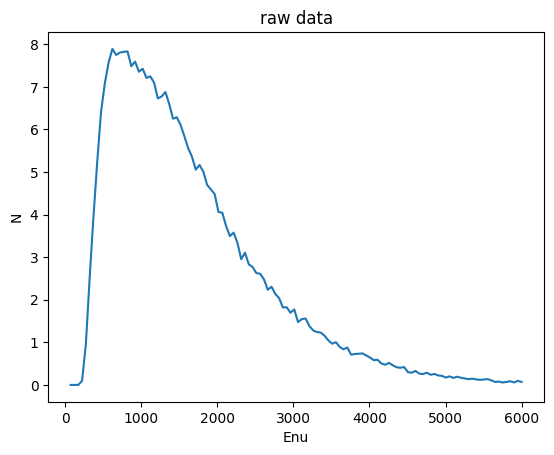

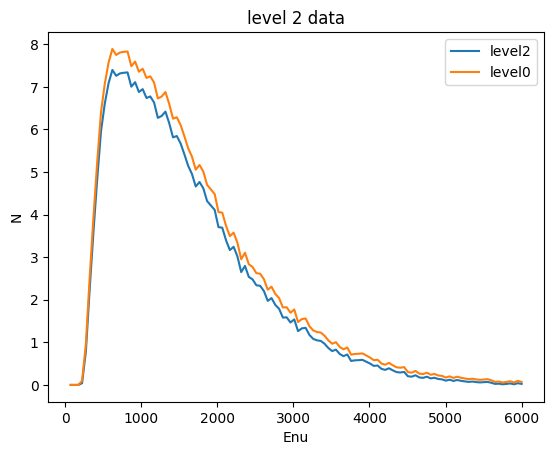

In [5]:
for i in range(num_obs):
    plt.plot(xvals_per_obs[i],events_per_obs[i])
    plt.xlabel(xlabels[i])
    plt.ylabel('N')
    plt.title("raw data")
    plt.show()

start = 0
for i in range(num_obs):
    plt.plot(
        xvals_per_obs[i], level2[0][start : len(events_per_obs[i]) + start], label="level2"
    )
    plt.plot(xvals_per_obs[i], events_per_obs[i],label="level0")
    plt.xlabel(xlabels[i])
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()
    start += len(events_per_obs[i])

In [6]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
    
        return y

In [27]:
import torch.nn as nn

if preproc == 0:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        def forward(self, x):
            return self.alpha*x
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            x = self.preprocessing(x)
            x = self.mlp(x)
            return x
        
if preproc == 1:
    print('if')
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

        def forward(self, x):
            return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            # x = self.preprocessing(x)
            x = self.mlp(x)
            return x
        
if preproc == 2:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma,a,epsilon):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32, requires_grad=True))
            self.epsilon = nn.Parameter(torch.tensor(epsilon, dtype=torch.float32, requires_grad=True))

        def forward(self, x):
            return self.a * x**(-self.alpha) * (1-x)**self.beta * (1+self.epsilon*x**0.5 + self.gamma*x)
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,a,epsilon,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma,a,epsilon)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            # x = self.preprocessing(x)
            x = self.mlp(x)
            return x
# else:
#     print('else')
#     class CustomPreprocessing(nn.Module):
#         def __init__(self, alpha):
#             super(CustomPreprocessing, self).__init__()
#             self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
#         def forward(self, x):
#             return self.alpha*x
        
#     class PreprocessedMLP(nn.Module):
#         def __init__(self, alpha,l1, l2, l3):
#             super(PreprocessedMLP, self).__init__()
#             self.preprocessing = CustomPreprocessing(alpha)
#             self.mlp = SimplePerceptron(l1, l2, l3)

#         def forward(self, x):
#             x = self.preprocessing(x)
#             x = self.mlp(x)
#             return x

if


In [28]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,
    positivity,
    lag_mult_pos,
    integrability,
    x_integrability,
    y_integrability,):
        loss = complete_loss_fct(pred,
    data,
    cov_matrix,
    positivity,
    lag_mult_pos,
    integrability,
    x_integrability,
    y_integrability,
    lag_mult_int)
        return loss

In [29]:
#Define variables for fit
x_alpha_more_bins = np.logspace(-8,0,1000)
x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys  = [],[],[],[],[],[],

In [30]:
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):

        if preproc == 0:
            alpha = 10
            model = PreprocessedMLP(alpha,l1, l2, l3)

        if preproc == 1:
            alpha,beta,gamma = -2.6,100,1000000
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

        if preproc == 2:    
            # alpha,beta,gamma,epsilon, a= -1.5,26,1,2000,2000
            alpha, beta, gamma, epsilon, a = 0.7, 30, 40000, -800, 0.6
            model = PreprocessedMLP(alpha, beta, gamma,a,epsilon,l1, l2, l3)
            
        # else:
        #     alpha = 10
        #     model = PreprocessedMLP(alpha,l1, l2, l3)
            
        # Loss and optimizer
        criterion = CustomLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        pred[i] = pred[i].squeeze()

        model.train()

        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 0

        while counter < max_counter:  
            if num_epochs>max_Nepochs:
                break 
            num_epochs+=1
            
            optimizer.zero_grad()

            y_pred =  model(torch.stack(x_alphas))
            y_preds = torch.matmul(fk_tables,y_pred)  * binwidths[:,None,None]
            # y_preds = torch.matmul(fk_tables,y_pred)  
            y_preds = y_preds[mask]
            y_integrability =  model(x_integrability)
            loss,pos_penalty,*_ = criterion(y_preds, pred[i],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)
            loss.backward()
            optimizer.step()
            print(loss)   

            if pos_penalty < 10**-6:
                if loss < best_loss:
                    best_loss = loss
                    counter = 0
                else:
                    counter +=1    
            else:
                counter +=1

        print(num_epochs) 
    
        loss, pos_penalty, int_penalty = criterion(y_preds, pred[i],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)
        red_chi_square_level1,*_ = criterion(y_preds, level1[0],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)

        print(f"reduced chi^2 level 2 = {loss}")
        print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
        print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
        # print(f"Constrained beta: {model.preprocessing.beta.item()}")
        # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

        # print('max_alpha,min_alpha,max_beta,min_beta')
        # print(compute_effective_coeff(model))

        # save outcome of fit and its measures for postfit selection criteria
        closure_fit = Postfit()
        arc_lenghts.append(closure_fit.compute_arc_length(model))
        chi_squares.append(loss.detach().numpy())
        pos_penaltys.append(pos_penalty.detach().numpy())
        int_penaltys.append(np.sqrt(int_penalty.detach().numpy()))
        N_event_pred.append(y_preds.detach().numpy())
        cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
        neutrino_pdfs.append(cont_pred)
    return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

In [31]:
arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS=1)

tensor(2.5483, grad_fn=<AddBackward0>)
tensor(2.5482, grad_fn=<AddBackward0>)
tensor(2.5481, grad_fn=<AddBackward0>)
tensor(2.5480, grad_fn=<AddBackward0>)
tensor(2.5479, grad_fn=<AddBackward0>)
tensor(2.5479, grad_fn=<AddBackward0>)
tensor(2.5478, grad_fn=<AddBackward0>)
tensor(2.5477, grad_fn=<AddBackward0>)
tensor(2.5476, grad_fn=<AddBackward0>)
tensor(2.5475, grad_fn=<AddBackward0>)
tensor(2.5474, grad_fn=<AddBackward0>)
tensor(2.5474, grad_fn=<AddBackward0>)
tensor(2.5473, grad_fn=<AddBackward0>)
tensor(2.5472, grad_fn=<AddBackward0>)
tensor(2.5471, grad_fn=<AddBackward0>)
tensor(2.5470, grad_fn=<AddBackward0>)
tensor(2.5469, grad_fn=<AddBackward0>)
tensor(2.5468, grad_fn=<AddBackward0>)
tensor(2.5468, grad_fn=<AddBackward0>)
tensor(2.5467, grad_fn=<AddBackward0>)
tensor(2.5466, grad_fn=<AddBackward0>)
tensor(2.5465, grad_fn=<AddBackward0>)
tensor(2.5464, grad_fn=<AddBackward0>)
tensor(2.5463, grad_fn=<AddBackward0>)
tensor(2.5463, grad_fn=<AddBackward0>)
tensor(2.5462, grad_fn=<A

In [32]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred,neutrino_pdfs)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
torch.Size([50])
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
delta chi^2 = -0.98853600025177
phi level 2 = 0.0
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


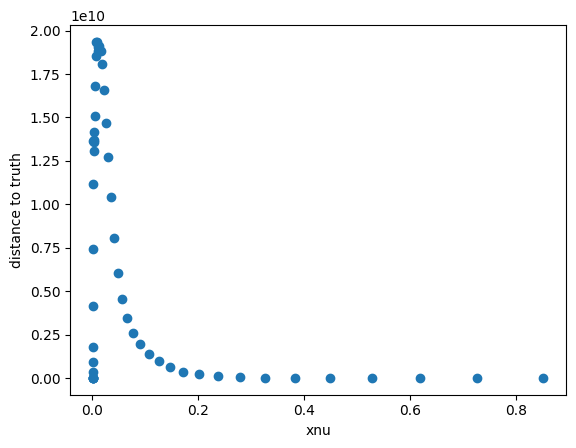

In [33]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, mask, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


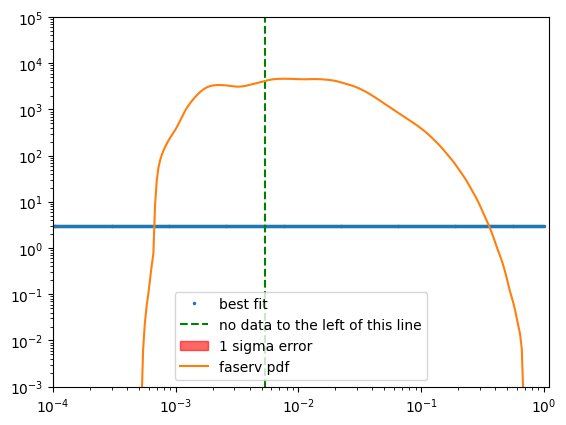

In [34]:
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
cont_x = x_alpha_more_bins.detach().numpy().flatten()
mean_neutrino_fit = np.mean(neutrino_pdfs,axis=0)
error_neutrino_fit = np.std(neutrino_pdfs,axis=0) 

plt.plot(cont_x,mean_neutrino_fit,'o',label="best fit",markersize=1.5)
plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.fill_between(cont_x,mean_neutrino_fit+error_neutrino_fit,mean_neutrino_fit-error_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.ylim(10**-3,10**5)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('neutrino_fit.pdf')
plt.show()

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_87504/2878806403.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')


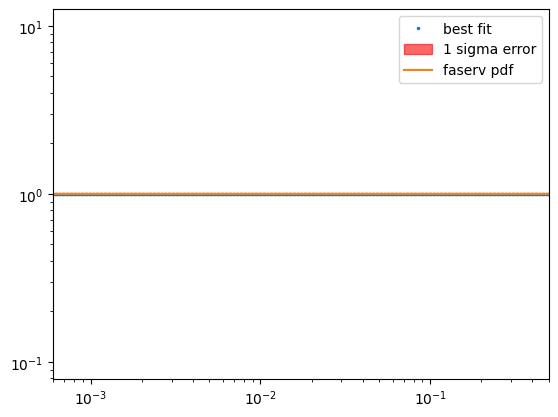

In [35]:
plt.plot(cont_x,mean_neutrino_fit/mean_neutrino_fit,'o',label="best fit",markersize=1.5)
plt.fill_between(cont_x,(mean_neutrino_fit+error_neutrino_fit)/mean_neutrino_fit,(mean_neutrino_fit-error_neutrino_fit)/mean_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')
plt.xlim(6*10**-4,0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

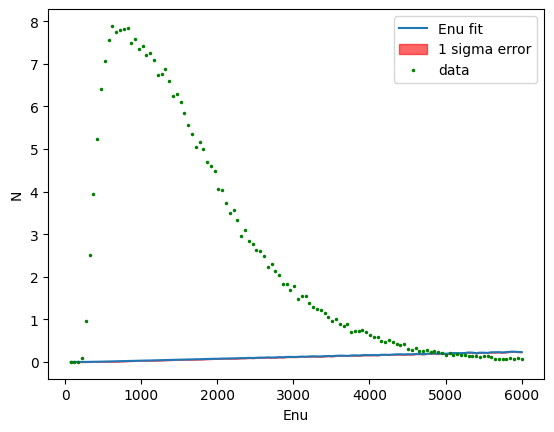

In [36]:
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)
start = 0
for i in range(num_obs):
    stop = len(xvals_per_obs[i])
    mean_N_event_fit = mean_N_event_fits[start:stop+start] 
    sigma_N_event_fit = sigma_N_event_fits[start:stop+start] 
    plt.plot(xvals_per_obs[i],mean_N_event_fit,label=f"{xlabels[i]} fit")
    
    plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs[i],events_per_obs[i],'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels[i]}')
    plt.ylabel('N')
    
    plt.legend()
    plt.show()
    start += stop

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_87504/400985866.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs[i],mean_N_event_fit/mean_N_event_fit,label=f"{xlabels[i]} fit")
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_87504/400985866.py:9: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_87504/400985866.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs[i],events_per_obs[i]/events_per_obs[i],'go',label='data',markersize=1.5)


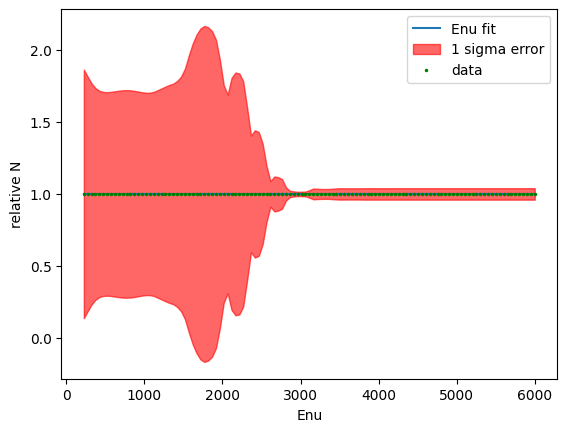

In [17]:
start = 0
for i in range(num_obs):
    stop = len(xvals_per_obs[i])
    mean_N_event_fit = mean_N_event_fits[start:stop+start] 
    sigma_N_event_fit = sigma_N_event_fits[start:stop+start] 
    
    plt.plot(xvals_per_obs[i],mean_N_event_fit/mean_N_event_fit,label=f"{xlabels[i]} fit")
    
    plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs[i],events_per_obs[i]/events_per_obs[i],'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels[i]}')
    plt.ylabel('relative N')
    
    plt.legend()
    plt.show()
    start += stop

In [18]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [19]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo